In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import bisect

In [2]:
MERGER_FILES = [
    "BBHmergers_catalog.dat",
    "BBHmergers_SSC.dat"
]
PROPERTIES = [
    ("model_num", int),
    ("rv", float),
    ("rg", int),
    ("Z", float),
    ("N", int),
    ("merger_time", float),
    ("id1", int),
    ("id2", int),
    ("m1", float),
    ("m2", float),
    ("spin1", float),
    ("spin2", float),
    ("v_kick", float),
    ("v_esc", float),
    ("merger_channel", int),
    ("id3", int),
    ("m3", float),
    ("spin3", float),
    ("a_final", float),
    ("e_final", float),
    ("e_10hz", float)
]

MERGER_CHANNELS = {
    1: "Ejected",
    2: "In-cluster 2-body",
    3: "In-cluster 3-body",
    4: "In-cluster 4-body",
    5: "In-cluster single-single capture"
}

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "font.size": 20,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.titlesize": 18
})

In [3]:
class BlackHole:
    def __init__(this, model, id, mass, spin):
        this.model = model
        model.bhs[id] = this
        this.id = id
        this.mass = mass
        this.spin = spin
        this.gen = 1

    def __str__(this):
        a = f"BH {this.id} from model {this.model.id}: mass {this.mass}, spin {this.spin}, gen {this.gen}"
        if hasattr(this, "parent"):
            a += f", parent {this.parent.id}"
        if hasattr(this, "children"):
            a += f", children {str([bh.id for bh in this.children])}"
        return a

class MergeEvent:
    def __init__(this, model, t, bh1, bh2, bh3, channel):
        this.model = model
        this.time = t
        this.bh1 = bh1
        this.bh2 = bh2
        this.bh3 = bh3
        this.channel = channel
        
        bh1.merge = this
        bh2.merge = this
        bh3.children = [bh1, bh2]
        bh1.parent = bh3
        bh2.parent = bh3
        bh3.gen = max(bh1.gen, bh2.gen) + 1

        model.mergers.append(this)

    def __str__(this):
        return f"Merge between {this.bh1.id} and {this.bh2.id} from model {this.model.id}"

class Model:
    def __init__(this, id, rv, rgc, z, n):
        this.id = id
        this.rv = rv
        this.rgc = rgc
        this.z = z
        this.n = n

        this.bhs = {}
        this.mergers = []

    def __str__(this):
        return f"Model {this.id}: rv {this.rv}, rgc {this.rgc}, z {this.z}, n {this.n}, bhs {len(this.bhs.keys())}, mergers {len(this.mergers)}"

In [4]:
def getCurrentBh(model, id):
    while id in model.bhs and hasattr(model.bhs[id], "parent"):
        id = model.bhs[id].parent.id
    return id

models = {}

start = time.time()
numModels = 0
numMergers = 0

for FILE in MERGER_FILES:
    with open(FILE) as file:
        for line in file.readlines():
            if line[0] == "#":
                continue
    
            lineData = line.split()
            if len(lineData) != len(PROPERTIES):
                continue
            merger = {}
            for index, field in enumerate(lineData):
                propName = PROPERTIES[index][0]
                propType = PROPERTIES[index][1]
                merger[propName] = propType(float(field))
            
            model = None
            if merger["model_num"] not in models:
                model = Model(merger["model_num"], merger["rv"], merger["rg"], merger["Z"], merger["N"])
                models[merger["model_num"]] = model
                numModels += 1
            else:
                model = models[merger["model_num"]]

            if merger["id3"] == merger["id1"] or merger["id3"] == merger["id2"]:
                merger["id3"] = merger["id1"] + merger["id2"]
            
            merger["id1"] = getCurrentBh(model, merger["id1"])
            merger["id2"] = getCurrentBh(model, merger["id2"])

            while merger["id3"] in model.bhs or merger["id3"] == merger["id1"] or merger["id3"] == merger["id2"]:
                merger["id3"] += 1
    
            bhs = [None, None, None]
            for index in ["1", "2", "3"]:
                if merger["id" + index] in model.bhs:
                    bhs[int(index) - 1] = model.bhs[merger["id" + index]]
                else:
                    bhs[int(index) - 1] = BlackHole(model, merger["id" + index], merger["m" + index], merger["spin" + index])
            bhs[2].ejected = merger["v_esc"] <= merger["v_kick"]
            bhs[0].ejected = bhs[1].ejected = False
                    
            mergeEvent = MergeEvent(model, merger["merger_time"], bhs[0], bhs[1], bhs[2], merger["merger_channel"])
            numMergers += 1

print(f"{numModels} models with {numMergers} mergers processed in {'{:.4f}'.format(time.time() - start)}s")

116 models with 10910 mergers processed in 0.1835s


In [5]:
def modelFilter(models, rv=-1, rgc=-1, z=-1, n=-1, verbose=False, labels=True):
    reqLabels = ["rv", "rgc", "z", "n"]
    requirements = [rv, rgc, z, n]
    out = []
    for model in models.values():
        vals = [model.rv, model.rgc, model.z, model.n]
        if all([(val == req or req == -1 or (isinstance(req, list) and val in req)) for req, val in zip(requirements,vals)]):
            label = f"model={model.id}"
            for reqLabel, requirement in zip(reqLabels, requirements):
                if requirement == -1:
                    label += f", {reqLabel}={getattr(model, reqLabel)}"
            if labels:
                out.append((model,label))
            else:
                out.append(model)
            if verbose:
                print(model)
    return out

In [6]:
def delayTimeGraph(models):
    plt.figure(figsize=(10,7))
    for model, label in models:
        times = []
        if type(model) == list:
            for submodel in model:
                times += [merger.time for merger in submodel.mergers]
        else:
            times = [merger.time for merger in model.mergers]
        counts, bin_edges = np.histogram(times, bins=30, range=(0, 14000), density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.plot(bin_centers, counts, marker='o', linestyle='-', label=label)
    plt.xlabel("Time (Myr)")
    plt.ylabel("Merger density")
    plt.title("Delay-time distribution of mergers")
    plt.legend()
    plt.show()

In [7]:
delayTimeGraph(modelFilter(models, rv=2.0, rgc=20.0, z=0.002, verbose=True))

Model 101: rv 2.0, rgc 20, z 0.002, n 2, bhs 15, mergers 5
Model 102: rv 2.0, rgc 20, z 0.002, n 4, bhs 65, mergers 22
Model 103: rv 2.0, rgc 20, z 0.002, n 8, bhs 160, mergers 54
Model 104: rv 2.0, rgc 20, z 0.002, n 16, bhs 444, mergers 153
Model 149: rv 2.0, rgc 20, z 0.002, n 1, bhs 2736, mergers 1046


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1000x700 with 1 Axes>

In [8]:
delayTimeGraph(modelFilter(models, rv=2.0, rgc=20.0, n=16, verbose=True))

Model 100: rv 2.0, rgc 20, z 0.0002, n 16, bhs 471, mergers 166
Model 104: rv 2.0, rgc 20, z 0.002, n 16, bhs 444, mergers 153
Model 108: rv 2.0, rgc 20, z 0.02, n 16, bhs 427, mergers 151


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1000x700 with 1 Axes>

In [9]:
def cumulativeDelayTimeGraph(models):
    plt.figure(figsize=(10,7))
    timeStep = np.linspace(0, 14000, 30)
    for model, label in models:
        times = []
        total = 0
        if type(model) == list:
            for submodel in model:
                times += [merger.time for merger in submodel.mergers]
                total += len(submodel.mergers)
        else:
            times = [merger.time for merger in model.mergers]
            total = len(model.mergers)
        times.sort()
        counts = [bisect.bisect_left(times, step) / total for step in timeStep]
        plt.plot(timeStep, counts, marker='o', linestyle='-', label=label)
        
    plt.xlabel("Time (Myr)")
    plt.ylabel("Percentage of total mergers")
    plt.title("Cumulative time distribution of mergers")
    plt.legend()
    plt.show()

In [10]:
cumulativeDelayTimeGraph(modelFilter(models, rv=2.0, rgc=20.0, z=0.002, verbose=True))

Model 101: rv 2.0, rgc 20, z 0.002, n 2, bhs 15, mergers 5
Model 102: rv 2.0, rgc 20, z 0.002, n 4, bhs 65, mergers 22
Model 103: rv 2.0, rgc 20, z 0.002, n 8, bhs 160, mergers 54
Model 104: rv 2.0, rgc 20, z 0.002, n 16, bhs 444, mergers 153
Model 149: rv 2.0, rgc 20, z 0.002, n 1, bhs 2736, mergers 1046


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1000x700 with 1 Axes>

In [11]:
cumulativeDelayTimeGraph(modelFilter(models, rv=2.0, rgc=20.0, n=16, verbose=True))

Model 100: rv 2.0, rgc 20, z 0.0002, n 16, bhs 471, mergers 166
Model 104: rv 2.0, rgc 20, z 0.002, n 16, bhs 444, mergers 153
Model 108: rv 2.0, rgc 20, z 0.02, n 16, bhs 427, mergers 151


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1000x700 with 1 Axes>

In [12]:
cumulativeDelayTimeGraph(modelFilter(models, rv=2.0, rgc=20.0, n=8, verbose=True))

Model 99: rv 2.0, rgc 20, z 0.0002, n 8, bhs 198, mergers 67
Model 103: rv 2.0, rgc 20, z 0.002, n 8, bhs 160, mergers 54
Model 107: rv 2.0, rgc 20, z 0.02, n 8, bhs 124, mergers 43


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1000x700 with 1 Axes>

In [13]:
print(models.keys())

dict_keys([12, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149])


In [14]:
# rg 8 and 20 are the same (89-92)
# metallicity - (97-100)
# ratio of ejected vs in-cluster depending on n
# type of merger depending on n

In [15]:
modelGroups = {
    "n=2": [ # n=2, rg=8 or 20, z=any
        89, 97, 101
    ], 
    "n=4": [ # n=4, rg=8 or 20, z=any
        90, 98, 102
    ],
    "n=8": [ # n=8, rg=8 or 20, z=any
        91, 99, 103
    ],
    "n=16": [ # n=16, rg=8 or 20, z=any
        92, 100, 104
    ],
    "n=32": [
        146
    ],
    "n=100": [ # n=100, rg=8 or 20, z=any
        149
    ]
}
actualModels = [([models[i] for i in modelGroups[label]], label) for label in modelGroups]

In [16]:
cumulativeDelayTimeGraph(actualModels)

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1000x700 with 1 Axes>

In [17]:
def cumulativeDelayTimeType(models, totalNum=True):
    plt.figure(figsize=(10,7))
    timeStep = np.linspace(0, 14000, 30)
    for model, label in models:
        ejectedTimes = []
        notEjectedTimes = []
        total = 0
        if type(model) == list:
            for submodel in model:
                for merger in submodel.mergers:
                    if merger.channel == 1:
                        ejectedTimes.append(merger.time)
                    else:
                        notEjectedTimes.append(merger.time)
                total += len(submodel.mergers)
        else:
            for merger in model.mergers:
                if merger.channel == 1:
                    ejectedTimes.append(merger.time)
                else:
                    notEjectedTimes.append(merger.time)
            total = len(model.mergers)
        ejectedTimes.sort()
        notEjectedTimes.sort()

        ejectedCounts = [bisect.bisect_left(ejectedTimes, step) / (total if totalNum else len(ejectedTimes)) for step in timeStep]
        notEjectedCounts = [bisect.bisect_left(notEjectedTimes, step) / (total if totalNum else len(notEjectedTimes)) for step in timeStep]
        ejectedPlot = plt.plot(timeStep, ejectedCounts, marker='^', linestyle='-', label=label)
        notEjectedPlot = plt.plot(timeStep, notEjectedCounts, marker='o', linestyle='-', color=ejectedPlot[0].get_color())
        
    plt.xlabel("Time (Myr)")
    plt.ylabel("Percentage of total mergers")
    plt.title("Cumulative time distribution of mergers")
    plt.legend()
    plt.show()

In [18]:
cumulativeDelayTimeType(actualModels,totalNum=False)

ZeroDivisionError: division by zero

Error in callback <function _draw_all_if_interactive at 0x0000011D8AD0F100> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1000x700 with 1 Axes>

In [ ]:
def ejectedRatioHistogram(models):
    totalMergers = []
    ejectedCounts = []
    notEjectedCounts = []
    modelLabels = []
    
    for model, label in models:
        if type(model) == list:
            tot = sum([len(submodel.mergers) for submodel in model])
            totalMergers.append(tot)
            ejectedCounts.append(sum([sum([1 for merger in submodel.mergers if merger.channel == 1]) for submodel in model]) / tot)
            notEjectedCounts.append(sum([sum([1 for merger in submodel.mergers if not merger.channel == 1]) for submodel in model]) / tot)
        else:
            tot = len(model.mergers)
            totalMergers.append(tot)
            ejectedCounts.append(sum([1 for merger in model.mergers if merger.channel == 1]) / tot)
            notEjectedCounts.append(sum([1 for merger in model.mergers if not merger.channel == 1]) / tot)
            print(totalMergers[-1], ejectedCounts[-1], notEjectedCounts[-1])
        modelLabels.append(label)
    
    plt.figure(figsize=(10, 6))
    plt.bar(modelLabels, notEjectedCounts, label='In-Cluster', color='blue')
    plt.bar(modelLabels, ejectedCounts, bottom=notEjectedCounts, label='Ejected', color='orange')
    
    plt.ylabel('Number of mergers')
    plt.title('Mergers per model')
    plt.legend(loc=2)
    plt.xticks(modelLabels)
    plt.show()

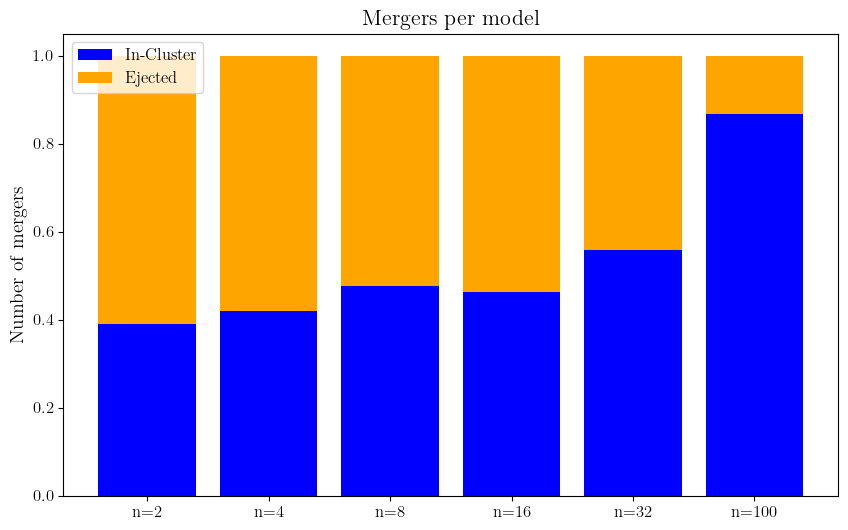

In [ ]:
ejectedRatioHistogram(actualModels)

5 0.6 0.4
22 0.6363636363636364 0.36363636363636365
54 0.5370370370370371 0.46296296296296297
153 0.5686274509803921 0.43137254901960786
417 0.4412470023980815 0.5587529976019184
1206 0.13266998341625208 0.867330016583748


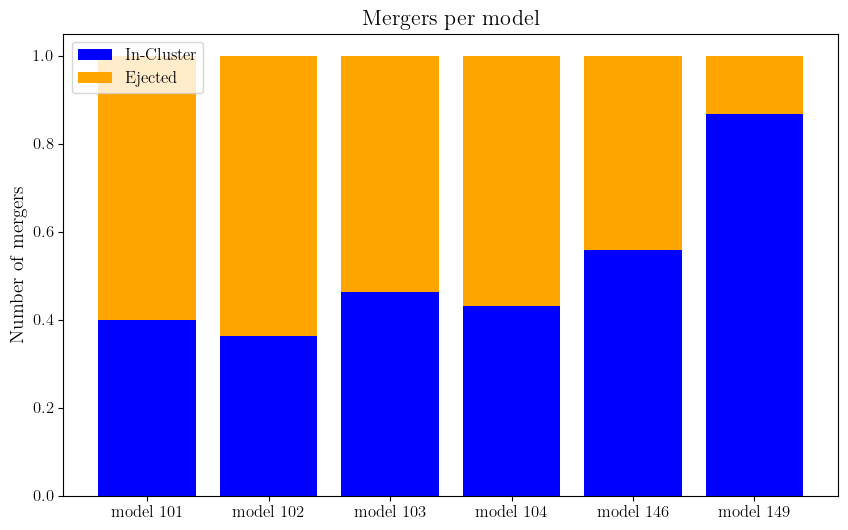

In [ ]:
ejectedRatioHistogram([(models[x],f'model {x}') for x in [101,102,103,104,146,149]])